# **_Time Series Prediction_**

<br>

### __*Import Libraries*__
### __*[DataTable](https://datatable.readthedocs.io/en/latest/start/quick-start.html)*__

In [345]:
# Datasets
import datatable as dt
import matplotlib.pyplot as plt

# Torch libraries
import torch
from torch import nn, optim

# Data Analysis
import PyDataWiser

# Device config
device = PyDataWiser.model.pick_device(show_device=True)

Using the Graphics Card cuda


<br>

### __*Prepare & Show Weather Data*__

In [346]:
# Show structure of dataset
weather_raw = dt.fread('data/seattle-weather.csv').to_pandas()
weather_raw.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


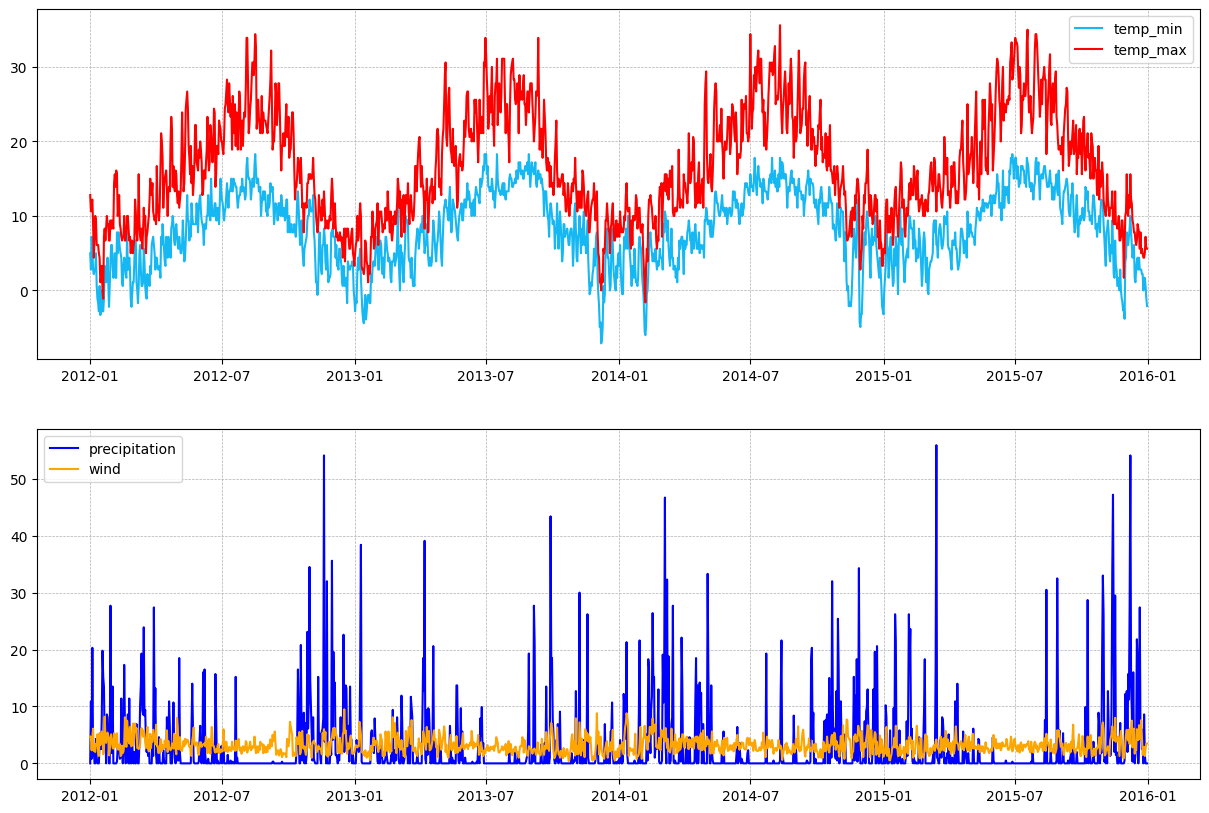

In [347]:
# Create a plot
fig_weather, axs_weather = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

min_plot, = axs_weather[0].plot(weather_raw['date'], weather_raw['temp_min'],
                                label='temp_min', color='#16b8f3')
max_plot, = axs_weather[0].plot(weather_raw['date'], weather_raw['temp_max'],
                                label='temp_max', color='red')

precipitation, = axs_weather[1].plot(weather_raw['date'], weather_raw['precipitation'],
                                     label='precipitation', color='blue')
wind_plot, = axs_weather[1].plot(weather_raw['date'], weather_raw['wind'],
                                 label='wind', color='orange')

axs_weather[0].grid(linestyle='--', linewidth=0.5)
axs_weather[0].legend(handles=[min_plot, max_plot])
axs_weather[1].grid(linestyle='--', linewidth=0.5)
axs_weather[1].legend(handles=[precipitation, wind_plot])
pass

<br>

### __*Prepare & Show Google Stock Data*__

In [348]:
# Show structure of dataset
goog_raw = dt.fread('data/GOOG.csv').to_pandas()
goog_raw.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,False,True
1,GOOG,2016-06-15,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,False,True
2,GOOG,2016-06-16,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,False,True
3,GOOG,2016-06-17,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,False,True
4,GOOG,2016-06-20,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,False,True


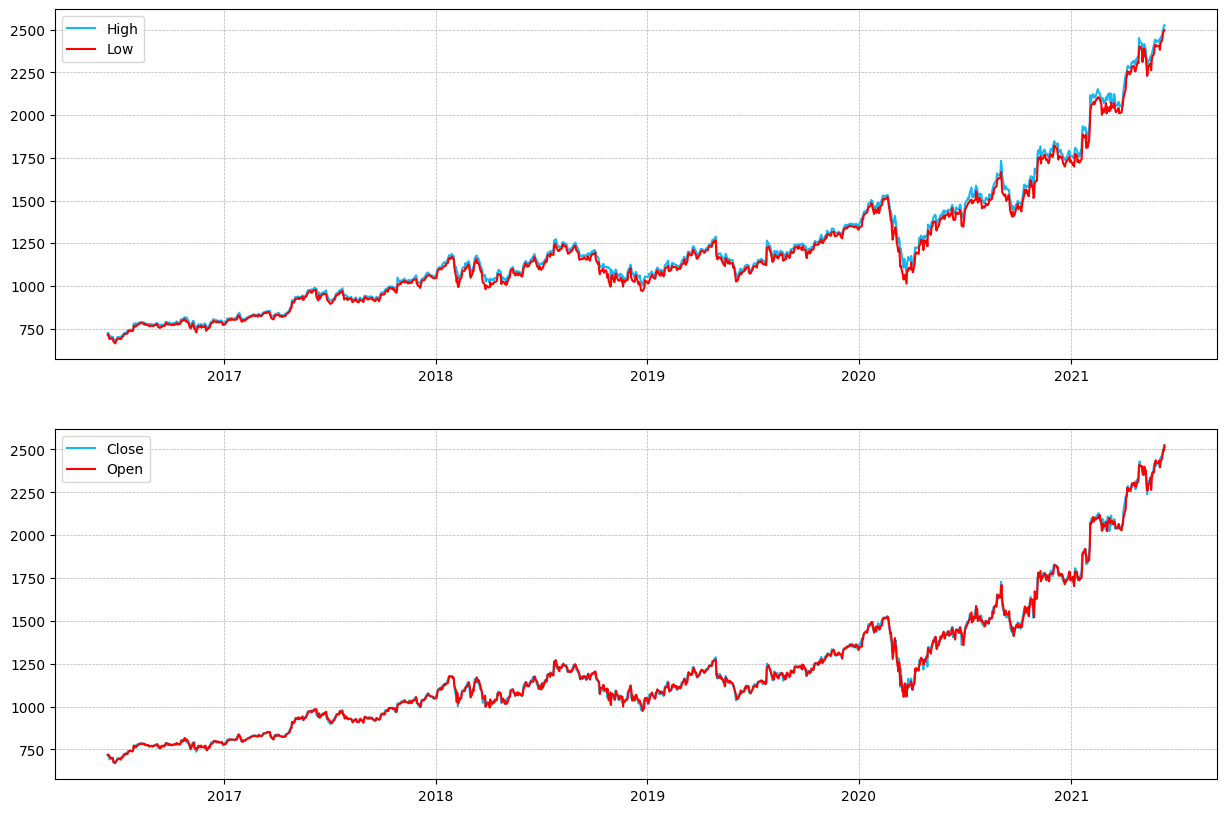

In [349]:
# Create a plot
fig_goog, axs_goog = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

close_plot, = axs_goog[1].plot(goog_raw['date'], goog_raw['close'],
                               label='Close', color='#16b8f3')
high_plot, = axs_goog[0].plot(goog_raw['date'], goog_raw['high'],
                              label='High', color='#16b8f3')
low_plot, = axs_goog[0].plot(goog_raw['date'], goog_raw['low'],
                             label='Low', color='red')
open_plot, = axs_goog[1].plot(goog_raw['date'], goog_raw['open'],
                              label='Open', color='red')

axs_goog[0].grid(linestyle='--', linewidth=0.5)
axs_goog[0].legend(handles=[high_plot, low_plot])
axs_goog[1].grid(linestyle='--', linewidth=0.5)
axs_goog[1].legend(handles=[close_plot, open_plot])
pass

<br>

### __*Prepare dataset*__

In [350]:
# # Testing of the Class
# raw = dt.fread('data/NASDAQ.csv').to_pandas()
# analysis = PyDataWiser.DataAnalysis(raw, None)
# analysis.pick_features(['Close', 'High', 'Low', 'Open', 'Volume'])
#
# analysis.create_dataset('Close', False, 'Low', False)
#
# X_train, X_test, y_train, y_test = analysis.data_tt_split(test_split=0.05, randomize=False, rand_state=None)
#
# analysis.create_report()

In [351]:
# Testing of the Class
raw = dt.fread('data/GOOG.csv').to_pandas()
analysis = PyDataWiser.DataAnalysis(raw, None, 40, 5)
analysis.pick_features(['close', 'high', 'low', 'open', 'volume'])

analysis.create_dataset('close', True, 'low', True)

X_train, X_test, y_train, y_test = analysis.data_tt_split(test_split=0.2, randomize=True, rand_state=None)

analysis.create_report()

<br>

### __*Create the Model*__

In [352]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # 256
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, output_size)

    def forward(self, xx):
        xx = torch.relu(self.fc1(xx))
        # xx = torch.relu(self.fc2(xx))
        # xx = torch.relu(self.fc3(xx))
        return self.fc4(xx)

In [353]:
reg_model = LinearRegression(200, 1)

train_loss_lst = list()
test_loss_lst = list()
train_acc = list()
test_acc = list()

In [354]:
num_epochs = 100
len_train = len(X_train)
batch = 2000

criterion = nn.MSELoss()                                   # L1Loss
optimizer = optim.AdamW(reg_model.parameters(), lr=0.0001)     # AdamW 0.0001

for epoch in range(num_epochs):
    total_loss = 0
    tmp_outputs = list()
    for delta in range(int(len_train/batch) + 1):
        if delta == int(len_train/batch):
            inputs = X_train[batch*delta:]
            targets = y_train[batch*delta:]
        else:
            inputs = X_train[batch*delta:batch*(delta+1)]
            targets = y_train[batch*delta:batch*(delta+1)]

        # Forward pass
        outputs = reg_model(inputs)
        tmp_outputs.append(outputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    predictions = reg_model(X_test)
    acc = criterion(predictions, y_test)

    train_loss_lst.append(total_loss/(len_train/batch))
    test_loss_lst.append(acc.item())
    train_acc.append(analysis.comparison(tmp_outputs, 'train')[1])
    test_acc.append(analysis.comparison(predictions)[1])


    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}:\n'
              f'  Train Loss: {(total_loss/(len_train/batch)):.10f} | Train Acc {(train_acc[-1]*100):.2f}%\n'
              f'  Test  Loss: {acc.item():.10f} | Test  Acc {(test_acc[-1]*100):.2f}%')

        total_loss = 0

C:\Users\rposa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([195])) that is different to the input size (torch.Size([195, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\rposa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100:
  Train Loss: 4.6055842669 | Train Acc 47.18%
  Test  Loss: 0.3154658377 | Test  Acc 48.98%
Epoch 2/100:
  Train Loss: 3.4969987013 | Train Acc 47.18%
  Test  Loss: 0.2282219380 | Test  Acc 51.02%
Epoch 3/100:
  Train Loss: 2.5598545869 | Train Acc 47.69%
  Test  Loss: 0.1576990783 | Test  Acc 51.02%
Epoch 4/100:
  Train Loss: 1.7923297026 | Train Acc 48.21%
  Test  Loss: 0.1035209745 | Test  Acc 53.06%
Epoch 5/100:
  Train Loss: 1.1917410753 | Train Acc 49.23%
  Test  Loss: 0.0648401603 | Test  Acc 57.14%
Epoch 6/100:
  Train Loss: 0.7504512866 | Train Acc 50.26%
  Test  Loss: 0.0405268148 | Test  Acc 61.22%
Epoch 7/100:
  Train Loss: 0.4575682756 | Train Acc 51.79%
  Test  Loss: 0.0289718043 | Test  Acc 59.18%
Epoch 8/100:
  Train Loss: 0.2978838216 | Train Acc 53.85%
  Test  Loss: 0.0280841924 | Test  Acc 61.22%
Epoch 9/100:
  Train Loss: 0.2504993517 | Train Acc 47.18%
  Test  Loss: 0.0351749659 | Test  Acc 53.06%
Epoch 10/100:
  Train Loss: 0.2885395136 | Train Acc 51

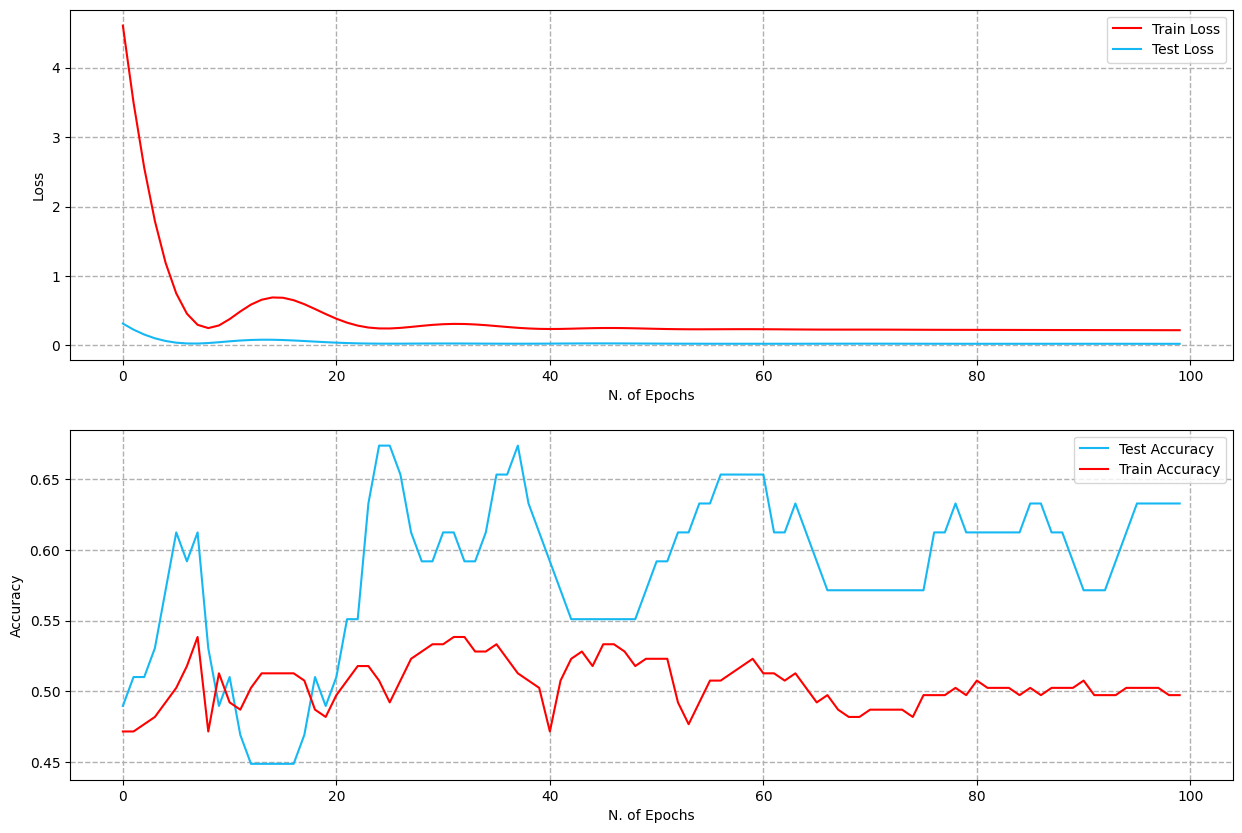

In [355]:
# Graphical representation of the learning process
_, axs_loss = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

test_acc_plot, = axs_loss[1].plot(test_acc, label='Test Accuracy', color='#16b8f3')
train_acc_plot, = axs_loss[1].plot(train_acc, label='Train Accuracy', color='red')
axs_loss[1].legend(handles=[test_acc_plot, train_acc_plot])
axs_loss[1].grid(linestyle='--', linewidth=1)
axs_loss[1].set_xlabel('N. of Epochs')
axs_loss[1].set_ylabel('Accuracy')

test_loss_lst_plot, = axs_loss[0].plot(test_loss_lst, label='Test Loss', color='#16b8f3')
train_loss_lst_plot, = axs_loss[0].plot(train_loss_lst, label='Train Loss', color='red')
axs_loss[0].legend(handles=[train_loss_lst_plot, test_loss_lst_plot])
axs_loss[0].grid(linestyle='--', linewidth=1)
axs_loss[0].set_xlabel('N. of Epochs')
axs_loss[0].set_ylabel('Loss')
pass

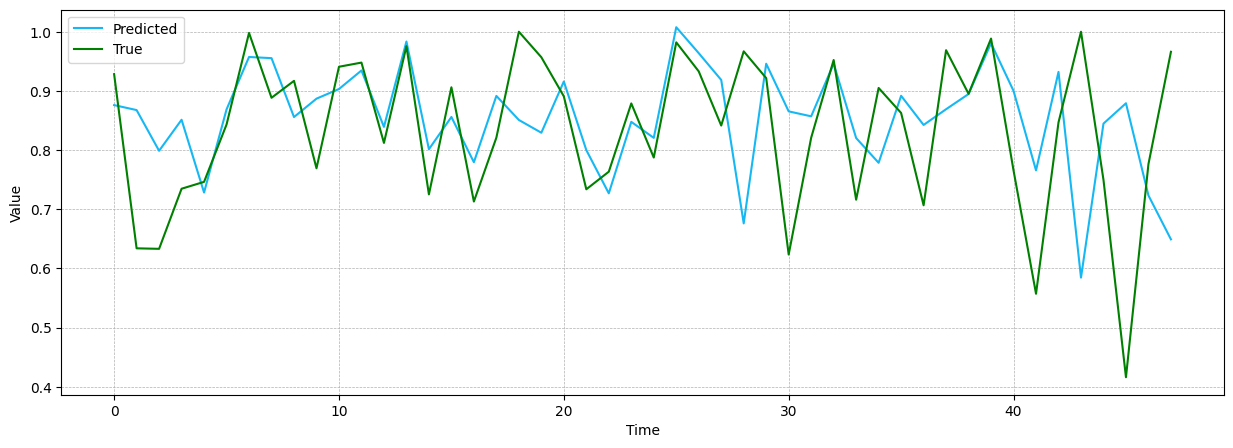

In [356]:
# Graphical representation of the model accuracy
start = 0
end = -1

predictions = reg_model(X_test)

_, axs_loss = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
test_loss_lst_plot, = axs_loss.plot(predictions.detach().numpy()[start:end], label='Predicted', color='#16b8f3')
train_loss_lst_plot, = axs_loss.plot(y_test[start:end], label='True', color='green')
axs_loss.legend(handles=[test_loss_lst_plot, train_loss_lst_plot])
axs_loss.grid(linestyle='--', linewidth=0.5)
axs_loss.set_xlabel('Time')
axs_loss.set_ylabel('Value')
pass

In [357]:
analysis.comparison(predictions, stats_table=True, print_stats=True)[0]

Accuracy: 63.27%
BUY Accuracy: 68.00%
SELL Accuracy: 58.33%


,Prior close,Today close,Guessed close,True,Pred
0,0.922430,0.928330,0.876038,Buy,Sell
1,0.602319,0.634067,0.867624,Buy,Buy
2,0.661497,0.633202,0.798838,Sell,Buy
3,0.733213,0.734738,0.851285,Buy,Buy
4,0.745301,0.746339,0.728329,Buy,Sell
5,0.899263,0.843237,0.868759,Sell,Sell
6,0.992411,0.997983,0.957331,Buy,Sell
7,0.885052,0.888402,0.955361,Buy,Buy
8,0.921900,0.916997,0.855832,Sell,Sell
9,0.785697,0.769284,0.886919,Sell,Buy
